<a href="https://colab.research.google.com/github/J0han-ai/fast.ai/blob/main/%D0%A1%D0%BE%D0%BB%D0%BE%D0%B2%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Подключите Google Drive к Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#импортируем необходимые библиотеки

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm

%matplotlib inline

In [3]:
#определим устройство, где проводить вычисления (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
#функция для вывода изображений
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))
#имена классов
classes = ("not_соловей", "соловей")

#путь до датасета
PATH = "/content/dataset"

загрузим тренировочный и тестовый наборы данных


In [5]:
# необходимо разпаковать датасеты в окружение, делается это так:архивируем каталоги в .zip и потом размещаем для закачки в нашу модель на своем Гугл_диске , в корне,  под названиями test.zip и train.zip.в виртуальной машине разархивированные файлы разместить в каталоге /content/dataset/ соответственно.
import zipfile
with zipfile.ZipFile('/content/gdrive/My Drive/test.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')
with zipfile.ZipFile('/content/gdrive/My Drive/train.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')
  

In [6]:
# зададим какие преобразования необходимо сделать с каждым изображением
transform = transforms.Compose(
    [transforms.Resize((64,64)),  #изменим размер изображений
     transforms.ToTensor(),   #переведем в формат который необходим нейронной сети - тензор
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) # проведем нормализацию изображения

#загружаем тренировочный и тестовый датасеты
trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "test"), transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=0, shuffle=True)


Real Labels:  not_соловей not_соловей not_соловей соловей


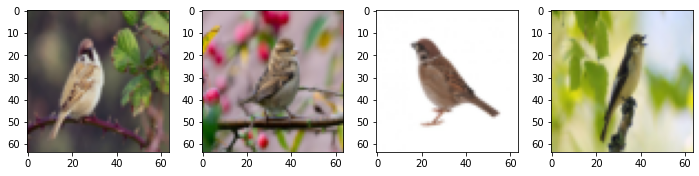

In [18]:
#Проверим как работает наш загрузчик и посмотрим на парочку изображений
images, labels = next(iter(trainloader))
image_shower(images, labels)

In [19]:
#загрузим нашу модель
model = torchvision.models.resnet18(pretrained=True)
#заморозим веса
for param in model.parameters():
    param.require = False

#так как у нас 2 класса, нужно переопределить последний слой сети под нашу задачу
#у предобученной сети было на выходе 1000 классов, поэтому в видео я сказал меняем 1000 на 2
model.fc = nn.Linear(512, 2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [20]:
#Зададим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [21]:
#Здесь будет тренировка нейронной сети

epochs = 10   #количество эпох (сколько раз будем тренировать)
model.to(device) #переносим нашу модель на GPU

for epoch in range(epochs):
    running_loss = 0.0
    #теперь в цикле проходим по нашему загрузчику данных
    for i, data in tqdm(enumerate(trainloader)):
        #каждый батч тоже помещаем на GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        #сбрасываем накопленный градиент 
        optimizer.zero_grad()
        #прогоняем изображения через модель, чтобы получить предсказание
        outputs = model(inputs)
        #рассчитываем функцию потерь (насколько хорошо предсказали)
        loss = criterion(outputs, labels)
        #считаем градиенты (обратный проход)
        loss.backward()
        #делаем шаг оптимизатора (обновляем веса)
        optimizer.step()

        running_loss += loss.item()

    print ("Epoch {} - Training loss: {} ".format(epoch, running_loss/len(trainloader)))

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
3it [00:02,  1.23it/s]
0it [00:00, ?it/s]

Epoch 0 - Training loss: 0.7715300520261129 


3it [00:02,  1.36it/s]
0it [00:00, ?it/s]

Epoch 1 - Training loss: 0.5832221607367197 


3it [00:02,  1.38it/s]
0it [00:00, ?it/s]

Epoch 2 - Training loss: 0.4301399787267049 


3it [00:02,  1.37it/s]
0it [00:00, ?it/s]

Epoch 3 - Training loss: 0.27567599217096966 


3it [00:02,  1.37it/s]
0it [00:00, ?it/s]

Epoch 4 - Training loss: 0.21816941599051157 


3it [00:02,  1.37it/s]
0it [00:00, ?it/s]

Epoch 5 - Training loss: 0.16696234544118246 


3it [00:02,  1.38it/s]
0it [00:00, ?it/s]

Epoch 6 - Training loss: 0.12687883277734122 


3it [00:02,  1.38it/s]
0it [00:00, ?it/s]

Epoch 7 - Training loss: 0.09128280977408092 


3it [00:02,  1.36it/s]
0it [00:00, ?it/s]

Epoch 8 - Training loss: 0.07678843041261037 


3it [00:02,  1.37it/s]

Epoch 9 - Training loss: 0.0810090812544028 


In [22]:
#посчитаем точность работы нашего классификатора
correct = 0
total = 0
with torch.no_grad():
    #переводим модель в режим инференса
    model.eval()
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        #получаем наши предсказания
        _, predicted = torch.max(outputs.data, 1)
        #посчитаем общее количество картинок
        total += labels.size(0)
        #посчитаем количество точно классифицированных картинок
        correct += (predicted == labels).sum().item()
print("Accuracy: %d" %(100 * correct/total))


Accuracy: 79


Посмотрим как работает наш классификатор изображений, сравним то что модель предсказывает Predicted (на основании данных с тренировочной выборки)
и контрольное значение Real Labels из тестовой выборки

---



Real Labels:  not_соловей not_соловей not_соловей not_соловей
Predicted:  not_соловей not_соловей not_соловей not_соловей


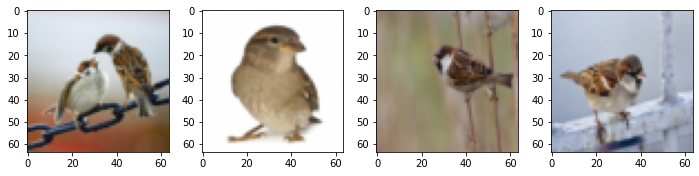

In [40]:
images, labels = next(iter(testloader))
image_shower(images, labels)

outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:4]))